# Lab 1: Introduction to Neural Networks
In this tutorial we introduce some of the concepts for working with neural networks using [Pytorch](https://pytorch.org/tutorials/recipes/recipes_index.html). The entire notebook can be executed as-is, given the lack of time for this first lab session. We encourage you to explore the code yourselves to get comfortable with the concepts of deel learning in the context of biology. A few questions at the end challenge you to play around with the code and try things for yourselves.

In this session, you will create a simple neural network that classifies any given DNA sequence as protein coding or not. As a starting point, we use as examples the coding DNA sequences from humans (homo sapiens (HS)). As negatives, we use random sequences of DNA where each nucleotide is drawn from a uniform distribution over the possible nucleotides. We then train a neural network on de [codon frequencies](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables) of these sequences.

In addition to human DNA sequences, we also take a look at coding sequences from mice ([mus musculus (MM)](https://en.wikipedia.org/wiki/House_mouse)) and yeast ([saccharomyces cerevisiae (SC)](https://en.wikipedia.org/wiki/Saccharomyces_cerevisiae)). There are subtle differences between the coding frequencies of these species. You will test how well your human-trained model is able to recover the coding sequences for mice and yeast (think of your results in the context of evolutionary distances between species). 


In [8]:

# import pytorch
import torch
import torch.nn as nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import KFold

# import basic functionality
import random
import numpy as np
import pandas as pd

# libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

import _pickle as pickle

import Bio
from Bio import SeqIO

# Step 1: Loading the data
For your convenience, we provide the pre-processed and encoded sequences. That is, we pre-processed human, mouse and yeast DNA sequences by filtering for coding sequences that contain an integer number of codons, that are of sufficient length for computing codon frequencies (>=300 base pairs), whose translation encodes a protein (start and stop codon). We removed duplicates and randomly mixed the sequences. 

We then encoded these sequences by computing the codon frequencies for each sequence. Here we load this data set. To train a neural network on de coding frequencies of these sequences, we encoded the sequences by converting each sequence to an array of frequencies for each possible codon. To do so, each codon gets assigned a index in the array. This array allows us to convert between codon (e.g., 'ATG') and indices in the array (e.g., 'ATG' -> 0) to keep track of the codon frequencies. We use Tensors - the datatype used for pytorch data - to store the coding frequencies.

Biologically, [DNA codons](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables) consist of three nucleotides, encoding amino acids. However, since we are training a neural network to classify a sequence to be protein coding or not, we can choose any number of nucleotides to represent a 'codon'. For example, we can choose a "codon length" of a single nucleotide (which would result in us training the model on the [frequencies of nucleotides in DNA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC403801/)), or a codon length of two nucleotides (no biological meaning as this does not represent a biological unit - we do not expect a model to learn any biology at all), or a codon length of 6 nucleotides (representing pairs of amino acids - would this yield a model that "learns" any biology?). You can play around with the yourself in the notebook that creates the codon frequencies, but we start with a codon length of 3 nucleotides - represeting one amino acid. 

Finally, for each human sequence, we also created a random sequence of codons following the same sequence length distribution as the DNA sequences. These nucleotides are drawn from a random uniform distribution over the possible codons. These random sequences are used as negatives (i.e., label = 1 will tell the model that a sequence is protein coding, label = 0 tells the model that a sequence is not protein coding). 

Download the data folder from [here](https://polybox.ethz.ch/index.php/s/qXpo8ZcsuHryxY0). If you would like (not required), you can read how the data was processed in "Lab1_bonus_encoding".


In [9]:

# downlaod pre-processed data from polybox - alternatively, run through the encoding notebook
!mkdir -p ~/all_seqs
%cd ~/

!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/icbbtCfCnJciTqD/download/lab1_seq_data_human_encoded_neg.obj
!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/Ln43QJDACXXGMNt/download/lab1_seq_data_human_encoded_pos.obj
!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/iaRDRWtYHpEpNYF/download/seq_data_mouse_encoded.obj
!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/95Gj7iXCWRFxp6D/download/seq_data_yeast_encoded.obj
!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/aekWxEGy8CYPKdM/download/sequence_encoding.obj
!wget -P ~/all_seqs/ https://polybox.ethz.ch/index.php/s/HNpgSK469MfZMLr/download/language.py
    

/home/course
--2026-02-18 11:15:51--  https://polybox.ethz.ch/index.php/s/icbbtCfCnJciTqD/download/lab1_seq_data_human_encoded_neg.obj
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52898477 (50M) [application/octet-stream]
Saving to: ‘/home/course/all_seqs/lab1_seq_data_human_encoded_neg.obj.1’

lab1_seq_data_human 100%[===================>]  50.45M   229MB/s    in 0.2s    

2026-02-18 11:15:52 (229 MB/s) - ‘/home/course/all_seqs/lab1_seq_data_human_encoded_neg.obj.1’ saved [52898477/52898477]

--2026-02-18 11:15:52--  https://polybox.ethz.ch/index.php/s/Ln43QJDACXXGMNt/download/lab1_seq_data_human_encoded_pos.obj
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52893439 (50M) [applicatio

In [10]:

# ensure we're in the right directory
%cd ~/all_seqs/

# load the encoded the sequence data
with open('lab1_seq_data_human_encoded_pos.obj', 'rb') as handle:
    seq_data_human_encoded_pos = pickle.load(handle)
    
with open('lab1_seq_data_human_encoded_neg.obj', 'rb') as handle:
    seq_data_human_encoded_neg = pickle.load(handle)
    
with open('seq_data_mouse_encoded.obj', 'rb') as handle:
    seq_data_mouse_encoded = pickle.load(handle)
    
with open('seq_data_yeast_encoded.obj', 'rb') as handle:
    seq_data_yeast_encoded = pickle.load(handle)
        
from language import Language
with open('sequence_encoding.obj', 'rb') as handle:
    dna_lang = pickle.load(handle)
    

/home/course/all_seqs


In [11]:

# take a look at the encoding
dna_lang.word2index


{'ATG': 0,
 'AAC': 1,
 'CTG': 2,
 'ACC': 3,
 'GAG': 4,
 'GAT': 5,
 'TGT': 6,
 'GTC': 7,
 'TTT': 8,
 'GTG': 9,
 'GCC': 10,
 'ATA': 11,
 'TAT': 12,
 'TTC': 13,
 'TCC': 14,
 'CAA': 15,
 'GAA': 16,
 'TGG': 17,
 'GGG': 18,
 'ATC': 19,
 'CTT': 20,
 'AAT': 21,
 'GCT': 22,
 'CAG': 23,
 'AGA': 24,
 'CAC': 25,
 'AGC': 26,
 'TTG': 27,
 'GCG': 28,
 'TCA': 29,
 'GTA': 30,
 'GGT': 31,
 'CAT': 32,
 'GGA': 33,
 'AAG': 34,
 'CCT': 35,
 'GTT': 36,
 'TCT': 37,
 'TTA': 38,
 'ACA': 39,
 'ATT': 40,
 'CCA': 41,
 'CCC': 42,
 'TGC': 43,
 'GAC': 44,
 'TAC': 45,
 'GCA': 46,
 'CTC': 47,
 'AGT': 48,
 'AGG': 49,
 'ACG': 50,
 'GGC': 51,
 'ACT': 52,
 'AAA': 53,
 'CTA': 54,
 'CGT': 55,
 'CGC': 56,
 'CGG': 57,
 'TCG': 58,
 'TAG': 59,
 'CCG': 60,
 'CGA': 61,
 'TAA': 62,
 'TGA': 63}

In [12]:

# take a look at a sample
seq_data_human_encoded_pos[0]


{'sequence': 'ATGAACCTGACCGAGGATTGTATGGTCTTTGAGGATGTGGCCATATATTTCTCCCAAGAGGAATGGGGGATCCTTAATGATGCTCAGAGACACCTGCACAGCAATGTGATGTTGGAGAACTTTGCGCTTTTGTCATCAGTAGGTTGTTGGCATGGAGCCAAGGATGAGGAGGTACCTTCCAAGCAGTGTGTTTCTGTAAGAGTGTTACAGGTCACAATTCCAAAGCCAGCTTTGTCCACCCTGAAGGCCCAGCCCTGCAAGATGTGTAGCTCAATTCTGAAGGACATTCTGCACCTGGCTGAGCACGATGGAACACACCCTGAGCAAGGGCTGTACACATGTGCAGCAGAGCATGACCTGCACCAAAAGGAGCAGATTAGAGAGAAGCTCACCAGAAGTGATGAGTGGAGGCCTTCATTTGTGAACCACAGTGCTCACGTGGGAGAGAGGAACTTCACATGCACGCAGGGTGGCAAGGATTTTACTGCCAGCTCAGACCTTCTCCAGCAACAGGTCTTAAACAGTGGGTGGAAGCTGTACAGGGATACCCAGGATGGGGAAGCCTTTCAAGGTGAACAGAATGATTTCAACTCCAGCCAAGGTGGGAAAGACTTTTGCCACCAACATGGGCTGTTTGAGCACCAAAAAACCCATAATGGGGAGAGGCCTTATGAGTTCAGTGAATGTGGGGAATTGTTTAGGTACAACTCCAACCTTATTAAATATCAGCAAAATCATGCTGGAGAAAGGCCTTATGAGGGCACTGAATATGGAAAGACCTTTATTAGAAAGTCCAACCTAGTTCAGCACCAGAAAATTCACAGTGAAGGCTTTCTTTCAAAAAGGTCTGACCCCATTGAACATCAGGAGATTCTCAGTAGACCAACACCTTATGAATGCACCCAGTGTGGGAAGGCCTTTCTTACACAGGCTCATCTGGTTGGTCACCAGAAAACCCATACTGGAGAACAGCCCTATGAATGCAA

In [13]:

# explore the correlation of coding frequencies across species
# first average and merge codon frequencies of the different species and random sequences
codon_freqs = pd.DataFrame([np.mean(np.array([ch['frequencies'] for ch in seq_data_human_encoded_pos if ch['label']==1]),axis=0),
                         np.mean(np.array([ch['frequencies'] for ch in seq_data_mouse_encoded if ch['label']==1]),axis=0),
                         np.mean(np.array([ch['frequencies'] for ch in seq_data_yeast_encoded if ch['label']==1]),axis=0),
                         np.mean(np.array([ch['frequencies'] for ch in seq_data_human_encoded_neg if ch['label']==0]),axis=0)
                         ]).T

# label codons and sort by human frequency
codon_freqs.index = [dna_lang.index2word[idx] for idx in list(codon_freqs.index)]
codon_freqs.reset_index(inplace=True)
codon_freqs.columns = ['codon','human','mouse','yeast','random']
codon_freqs.sort_values(by='human',ascending=False,inplace=True)

print('correlation matrix: ')
print(codon_freqs.set_index('codon').corr())


correlation matrix: 
           human     mouse     yeast    random
human   1.000000  0.992927  0.412935 -0.026486
mouse   0.992927  1.000000  0.414042 -0.044359
yeast   0.412935  0.414042  1.000000 -0.050874
random -0.026486 -0.044359 -0.050874  1.000000


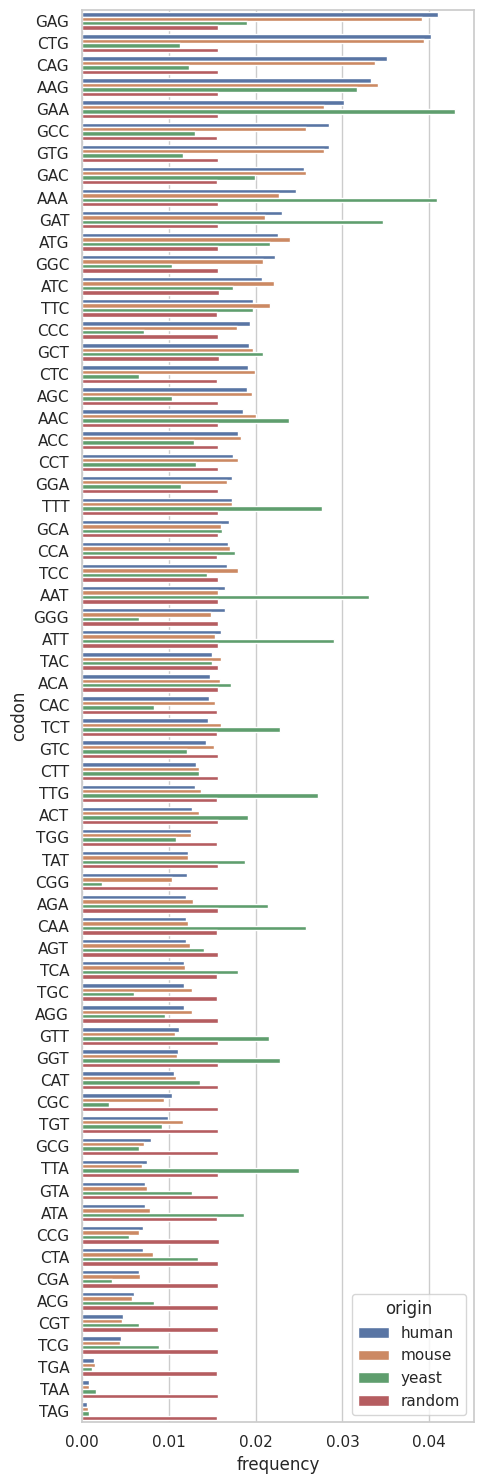

In [14]:

# plot coding frequencies for different species
# initialize figure
sns.set(rc={'figure.figsize':(5,15)})
sns.set(font="Arial")
sns.set(style="whitegrid")

# stack dataframe of frequencies
plot_freqs = codon_freqs.set_index('codon').stack().reset_index()
plot_freqs.columns = ['codon','origin','frequency']

# plot codon frequencies for different species
sns.barplot(data=plot_freqs,x='frequency',y='codon',hue='origin')
plt.tight_layout()
plt.show()


# Step 2: Creating a dataloader
Having encoded our DNA sequences as codon frequencies, we are ready to prepare the data for training a neural network. We will create a 'dataloader' that takes care of splitting the data into batches.

In [15]:

# merge encoded human sequences and the matching random samples
seq_data_human_encoded = seq_data_human_encoded_pos + seq_data_human_encoded_neg
random.shuffle(seq_data_human_encoded)

# split the sequence data that we defined above into training, validation and test sets
#train_set_human, val_set_human, test_set_human = torch.utils.data.random_split(seq_data_human_encoded, [0.5,0.4,0.1])
#train_set_mouse, val_set_mouse, test_set_mouse = torch.utils.data.random_split(seq_data_mouse_encoded, [0.5,0.4,0.1])
#train_set_yeast, val_set_yeast, test_set_yeast = torch.utils.data.random_split(seq_data_yeast_encoded, [0.5,0.4,0.1])

train_set_human, val_set_human, test_set_human = torch.utils.data.random_split(seq_data_human_encoded, [int(ch*len(seq_data_human_encoded)) for ch in [0.5,0.4,0.1]])
train_set_mouse, val_set_mouse, test_set_mouse = torch.utils.data.random_split(seq_data_mouse_encoded, [int(ch*len(seq_data_mouse_encoded)) for ch in [0.5,0.4,0.1]])


In [16]:

############################
# define a function to create a dataloader for the encoded sequences
def get_dataloader(dataset, batch_size):
    cur_sampler = RandomSampler(dataset)
    cur_dataloader = DataLoader(dataset=dataset, sampler=cur_sampler, batch_size=batch_size, drop_last=True, num_workers=16)
    return cur_dataloader    
############################


In [17]:

# how many samples should be trained on simultaneously?
batch_size = 300

# define dataloader for training
train_loader_human = get_dataloader(train_set_human, batch_size)
val_loader_human = get_dataloader(val_set_human, batch_size)
test_loader_human = get_dataloader(test_set_human, 1)


# Step 3: Define model
As a final preparation, we define our [model](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We create a class that instructs pytorch to follow a certain architecture for the model. Our model initializes all relevant parts (init function) and tells pytorch how to compute the output for a given input (forward function). For our perceptron, we use a single dense linear layer with a sigmoidal activation function. You can play around with the model architecture later - several options are left as comments.
We are trying to train a model for solving a classfication problem. The labels for our samples are binary (ones and zeros). We therefore use a binary loss function. 

In [18]:

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [19]:
# Define the model architecture by subclassing nn.Module (PyTorch's base class for all neural networks)
class myPerceptron(nn.Module):
    def __init__(self, input_param, output_param):
        super(myPerceptron, self).__init__()  # Initialize the parent nn.Module class
        
        self.input_param = input_param    # Store input size (64 codons)
        self.output_param = output_param  # Store output size (1 for binary classification)
        
        # --- Layers ---
        # Hidden layer 1: reduces 64 codon frequencies down to 32 features
        # nn.Linear(in, out) applies: output = input @ weight.T + bias
        self.linear0 = nn.Linear(input_param, 32)
        
        # Hidden layer 2: further compresses 32 features down to 16
        self.linear1 = nn.Linear(32, 16)
        
        # Output layer: maps 16 features to a single value (coding or not)
        self.linear2 = nn.Linear(16, output_param)
        
        # --- Activation functions ---
        # ReLU (Rectified Linear Unit): f(x) = max(0, x)
        # Introduces non-linearity between hidden layers so the model can learn
        # complex patterns beyond what a single linear layer could capture
        self.relu = nn.ReLU()
        
        # Dropout: randomly sets p=30% of neuron outputs to 0 during training
        # This forces the network not to rely on any single neuron,
        # acting as regularization to prevent overfitting
        # Note: dropout is automatically disabled during model.eval()
        self.dropout = nn.Dropout(p=0.3)
        
        # Sigmoid: squashes output to range (0, 1), interpretable as a probability
        # P=1 means "likely coding sequence", P=0 means "likely not coding"
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_data):
        # --- Forward pass: defines how data flows through the network ---
        
        # Layer 1: linear transformation → ReLU activation → dropout
        # Shape: (batch_size, 64) → (batch_size, 32)
        output_linear = self.relu(self.linear0(input_data))
        output_linear = self.dropout(output_linear)
        
        # Layer 2: linear transformation → ReLU activation → dropout
        # Shape: (batch_size, 32) → (batch_size, 16)
        output_linear = self.relu(self.linear1(output_linear))
        output_linear = self.dropout(output_linear)
        
        # Output layer: linear transformation only (no ReLU — we want raw values here)
        # Shape: (batch_size, 16) → (batch_size, 1)
        output_linear = self.linear2(output_linear)
        
        # Final sigmoid squashes the output to a probability between 0 and 1
        # BCELoss (used during training) expects values in this range
        output_activation = self.sigmoid(output_linear)
        
        return output_activation

In [20]:

# use binary cross entropy los for this classification problem
my_loss_function = nn.BCELoss()

# initialize an instance of our model class (a variable that is a model following the architecture we defined above)
my_model = myPerceptron(dna_lang.n_words, # size of input tensors (the number of codons)
                     1, # size of the model's output
                    ).to(device) # send model to device

# show model architecture
my_model


myPerceptron(
  (linear0): Linear(in_features=64, out_features=32, bias=True)
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

# Step 4: Train simple model 
To train our model, we need a "training loop". 
1) First, we tell pytorch that we want to train our model (so it has to keep track of gradients). 
2) We then iterate over our data in batches to speed up computations (there is little advantage for computing the gradient with all samples over, say, a few hundred samples). 
3) We set the gradients to zero (we don't want to re-use previous computations for our next training step).
4) We compute the output of the model for the given input sequences. 
5) We then compute the loss of the model output for the given target labels of the input sequences and [backpropagate](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) the loss through the network to compute the gradient. 
6) Finally, we instruct the optimizer to use the gradient and perform one appropriately-sized [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) to update the model weights. 
7) To keep track of our effors we compute the accuracy and training loss for the current samples.

Finally, we train our model using the given data and training loop

In [21]:

# Define the training loop
def train(model, train_loader, optimizer, device):
    # training mode
    model.train(True)
    
    # Enabling gradient calculation
    with torch.set_grad_enabled(True):
        collect_loss = 0
        correct = 0
        nr_samples = 0
        for batch_idx, data in enumerate(train_loader):
            # send features and labels to GPU/CPU
            model_input = data['frequencies'].to(device)
            target = data['label'].to(device)

            # zero the gradients
            model.zero_grad()
            optimizer.zero_grad()

            # compute output of model
            output = model(model_input)

            # compute the loss and update model parameters
            loss = my_loss_function(output, target)
            loss.backward()

            # adjust learning weights
            optimizer.step()
            
            # store training loss
            collect_loss += loss.item()*batch_size
            
            # compute accuracy of training data
            pred = torch.round(output,decimals=0)
            correct += (pred.eq(target.view_as(pred)).sum().item())
            nr_samples += len(target)
            
        return {'train_loss':collect_loss/nr_samples, 'train_accuracy':correct/nr_samples}
    

Similar to the training loop, we need a "test loop" to get the output of the model for a given set of validation samples on which we do not train the model. 
1) First, we tell pytorch that we do NOT want to train our model (no keeping track of gradients - evaluation mode). 
2) We then iterate over our validation data. 
3) We compute the output of the model for the given input sequences. 
4) We then compute the loss of the model output for the given target labels of the input sequences.
5) We compute the accuracy and training loss for the current samples.

In [22]:

# define the test loop
def validate(model, test_loader, device):
    # Evaluation mode
    model.eval()
    
    with torch.no_grad():
        collect_loss = 0
        correct = 0
        nr_samples = 0
        for data in test_loader:
            # send features and labels to GPU/CPU
            model_input = data['frequencies'].to(device)
            target = data['label'].to(device)
            
            # compute output of model
            output = model(model_input)

            # store test loss
            collect_loss += my_loss_function(output, target).item()*batch_size
            
            # compute accuracy for test data
            pred = torch.round(output,decimals=0)
            correct += (pred.eq(target.view_as(pred)).sum().item())
            nr_samples += len(target)
            
        return {'val_loss':collect_loss/nr_samples, 'val_accuracy':correct/nr_samples}
    

In [23]:

# define the number of epochs - how often should the model (my_model) see all of the data (train_loader_human)?
n_epochs = 20

# initialize an instance of our model class (a variable that is a model following the architecture we defined above)
my_model = myPerceptron(dna_lang.n_words, # size of input tensors (the number of codons)
                     1, # size of the model's output
                    ).to(device) # send model to device

# use stochastic gradient descent with the given learning rate
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.01)

# Train the model on the current data
stats_tracker = []
for epoch in range(0, n_epochs):
    # train the model and get training loss
    test_stats = validate(my_model, val_loader_human, device)
    train_stats = train(my_model, train_loader_human, optimizer, device)
    stats_tracker.append( train_stats|test_stats )
    print('epoch: ', epoch, train_stats, test_stats, '\t\t\t\t\t\t\t\t', end='\r')
    

epoch:  19 {'train_loss': 0.004384137809348899, 'train_accuracy': 0.9990909090909091} {'val_loss': 0.005256278630775273, 'val_accuracy': 0.9984905660377359} 										

In [26]:
# ============================================================
# QUESTION 4: Predict on Mouse and Yeast sequences
# Add this AFTER your training loop (after Step 4)
# ============================================================

# Set model to evaluation mode (disables dropout)
my_model.eval()

def evaluate_species(model, dataset, device, label_name):
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient needed, we're just predicting
        for sample in dataset:
            # Get codon frequencies and label for one sequence
            x = sample['frequencies'].unsqueeze(0).to(device)  # add batch dimension
            y = sample['label'].to(device)
            
            # Get model prediction
            output = model(x)
            pred = torch.round(output)  # round to 0 or 1
            
            correct += pred.eq(y.view_as(pred)).sum().item()
            total += 1
            
    acc = correct / total
    print(f"Accuracy on {label_name}: {acc:.4f} ({correct}/{total})")
    return acc

# Evaluate on each species using the model trained on HUMAN data
evaluate_species(my_model, seq_data_human_encoded_pos, device, "Human (positive)")
evaluate_species(my_model, seq_data_mouse_encoded,     device, "Mouse")
evaluate_species(my_model, seq_data_yeast_encoded,     device, "Yeast")

Accuracy on Human (positive): 0.9997 (19993/20000)
Accuracy on Mouse: 0.9984 (19969/20000)
Accuracy on Yeast: 0.8735 (5319/6089)


0.8735424536048613

In [28]:
# ============================================================
# QUESTION 5: Retrain model using Yeast / Mouse as negatives
# ============================================================
import copy

def make_cross_species_dataset(positive_data, negative_data):
    """
    positive_data: human coding sequences (label stays 1)
    negative_data: yeast/mouse sequences (label changed from 1 to 0)
    """
    relabeled_negatives = []
    for sample in negative_data:
        new_sample = copy.deepcopy(sample)        # copy so we don't overwrite original data
        new_sample['label'] = torch.tensor([0.])  # relabel yeast/mouse as 0 (non-human)
        relabeled_negatives.append(new_sample)
    
    combined = positive_data + relabeled_negatives
    random.shuffle(combined)
    return combined

# -----------------------------------
# Model 1: Human (1) vs Yeast (0)
# -----------------------------------
human_vs_yeast = make_cross_species_dataset(
    seq_data_human_encoded_pos,
    seq_data_yeast_encoded
)

# FIX: compute split sizes explicitly so they sum to total length
n_hy = len(human_vs_yeast)
train_hy, val_hy, test_hy = torch.utils.data.random_split(
    human_vs_yeast,
    [int(0.5*n_hy), int(0.4*n_hy), n_hy - int(0.5*n_hy) - int(0.4*n_hy)]  # remainder goes to test
)

train_loader_hy = get_dataloader(train_hy, batch_size)
val_loader_hy   = get_dataloader(val_hy, batch_size)

model_human_vs_yeast = myPerceptron(dna_lang.n_words, 1).to(device)
optimizer_hy = torch.optim.Adam(model_human_vs_yeast.parameters(), lr=0.01)

print("Training: Human (1) vs Yeast (0)")
for epoch in range(20):
    train_stats = train(model_human_vs_yeast, train_loader_hy, optimizer_hy, device)
    val_stats   = validate(model_human_vs_yeast, val_loader_hy, device)
    print(f"Epoch {epoch}: {train_stats} | {val_stats}", end='\r')

# -----------------------------------
# Model 2: Human (1) vs Mouse (0)
# -----------------------------------
human_vs_mouse = make_cross_species_dataset(
    seq_data_human_encoded_pos,
    seq_data_mouse_encoded
)

# FIX: same remainder fix as above
n_hm = len(human_vs_mouse)
train_hm, val_hm, test_hm = torch.utils.data.random_split(
    human_vs_mouse,
    [int(0.5*n_hm), int(0.4*n_hm), n_hm - int(0.5*n_hm) - int(0.4*n_hm)]
)

train_loader_hm = get_dataloader(train_hm, batch_size)
val_loader_hm   = get_dataloader(val_hm, batch_size)

model_human_vs_mouse = myPerceptron(dna_lang.n_words, 1).to(device)
optimizer_hm = torch.optim.Adam(model_human_vs_mouse.parameters(), lr=0.01)

print("\nTraining: Human (1) vs Mouse (0)")
for epoch in range(20):
    train_stats = train(model_human_vs_mouse, train_loader_hm, optimizer_hm, device)
    val_stats   = validate(model_human_vs_mouse, val_loader_hm, device)
    print(f"Epoch {epoch}: {train_stats} | {val_stats}", end='\r')

Training: Human (1) vs Yeast (0)
Epoch 19: {'train_loss': 0.07474551462503366, 'train_accuracy': 0.9852713178294573} | {'val_loss': 0.05145007864955593, 'val_accuracy': 0.9874509803921568}5}
Training: Human (1) vs Mouse (0)
Epoch 19: {'train_loss': 0.6068439492673585, 'train_accuracy': 0.6804040404040405} | {'val_loss': 0.5792533676579313, 'val_accuracy': 0.7032075471698114}

# Step 5: Plotting error and accuracy
Using the output from training, we can plot the results for each epoch to look at the learning of our model. For this, we average the errors over the different folds from training. Carefully look at the training and testing error to choose an appropriate number of epochs for training (to avoid overfitting). 

NOTE: the initial model included trains very fast with a small error and high accuracy. The error and accuracy become interesting when looking at training on other species as negative samples in the questions.

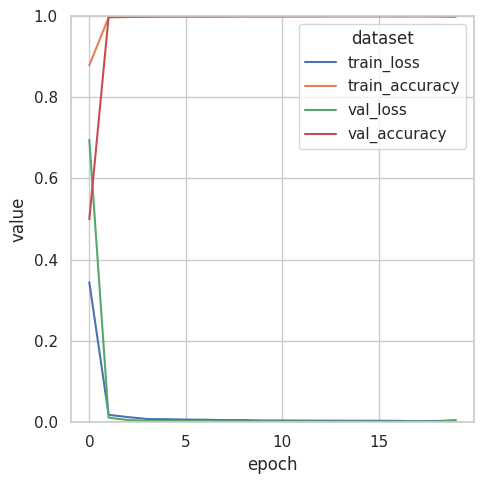

In [24]:

# initialize figure
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font="Arial")
sns.set(style="whitegrid")

# format loss data
plot_data = pd.DataFrame(stats_tracker)
plot_data = plot_data.stack().reset_index()
plot_data.columns = ['epoch','dataset','value']

# plot training and test loss as function of epoch
ax=sns.lineplot(data=plot_data, x='epoch', y='value',hue='dataset')
#ax.set_yscale('log')
ax.set_ylim([0,1])
plt.tight_layout()
plt.show()


In [25]:

# define function for evaluating the trained model for a given sample
def evaluate(model, sample):
    # set the model in evaluation mode without computing gradients
    model.eval()
    with torch.no_grad():
        # compute the output of the model for a given sample
        output = my_model(sample.to(device))
    return output.item()


# finally, using a trained model, we can compute a 'probability' that a given input sequence is encoding a protein
test_sampler = enumerate(test_loader_human)

# here we pick a random sequence that was not used for training, but you can change this to any sequence you would like 
batch_idx, test_sample = next(test_sampler)

# evaluate model for given test sample
output = evaluate(my_model, test_sample['frequencies'])

# print output of the model together with the label of the sample
print('probability: ',output, test_sample['label'])


probability:  1.0 tensor([[1.]])


# Step 6: Questions
1) how many parameters does your model have?
2) change model architecture, you can add more layers with hidden parameters, other activation functions, dropout parameters, etc. Make sure that the model does not overfit.
3) make predictions for mouse sequences using the model trained for human sequences. What changes for the accuracy? What happens if you make predictions for yeast sequences?
4) now train the model to use yeast sequences as negative samples for coding sequences. And then for mouse sequences as negative samples. This creates a model that learns to classify sequences as being likely from mice/yeast or from humans.
- Human vs. Yeast: easy task — very different codon usage (correlation ≈ 0.41 from your earlier plot), so the model should reach high accuracy
Human vs. Mouse: hard task — nearly identical codon usage (correlation ≈ 0.99), so the model will struggle to tell them apart
Now the model learns to distinguish:
Human coding sequences → label 1
Yeast/Mouse coding sequences → label 0 (used as the "negative")

# Step 7: Bonus (hard - use encoding notebook)
6) what happens if you change the codon length?
7) what happens to the probablities when sequences are frameshifted? can you train the model using frameshifted sequences as input?
8) train the model on amino acid frequencies instead of codons